### Задание
- Используя предобученные нейронные сети для задачи классификации изображений подобрать модель таким образом что бы метрики качества были максимальны. 
- Вывести графики обучения.
- Проанализировать результат.
- Использовать коллбэки для изменения скорости обучения и сохраннеия лучшей модели.
- Использовать набор данных с EuroSat  


### Анализ
- Используем предобученные сети ResNet, VGG, EfficientNet

### Имплементация


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import  models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

BATCH_SIZE = 256
EPOCHS = 100
LEARNING_RATE = 5e-4
NUM_CLASSES = 10

if torch.cuda.is_available():
    device = "cuda"
else:
    try:
        import torch_directml
        device = torch_directml.device()
    except:
        device = "cpu"


Подготовка и аугментация датасета

In [2]:
import ssl
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

ssl._create_default_https_context = ssl._create_unverified_context

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomVerticalFlip(p=0.25),
    transforms.RandomAffine(degrees=45, translate=(0.2, 0.2), scale=(0.7, 1.3), shear=20),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.EuroSAT(root='./data', transform=train_transform, download=True)
class_names = full_dataset.classes
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=16)

Функция обучения модели

In [3]:
from tqdm import tqdm
import torch

def train_model(model, model_name, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    best_accuracy = 0.0
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    epoch_loop = tqdm(range(num_epochs), desc='Training', leave=True)

    for epoch in epoch_loop:
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        train_loop = tqdm(train_loader, desc=f'Train Epoch {epoch+1}/{num_epochs}', leave=False)
        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            train_loop.set_postfix(loss=running_loss / len(train_loader), accuracy=100. * correct / total)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        test_loop = tqdm(test_loader, desc=f'Test Epoch {epoch+1}/{num_epochs}', leave=False)
        with torch.no_grad():
            for inputs, labels in test_loop:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                test_loop.set_postfix(loss=test_loss / len(test_loader), accuracy=100. * correct / total)

        test_loss = test_loss / len(test_loader)
        test_accuracy = 100. * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), f'best_model_{model_name}.pth')

        scheduler.step()
        epoch_loop.set_postfix(train_loss=train_loss, train_acc=train_accuracy, test_loss=test_loss, test_acc=test_accuracy)

    return train_losses, test_losses, train_accuracies, test_accuracies

Функции вывода графиков

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(train_losses, test_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.show()



def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap='Blues'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                xticklabels=classes, yticklabels=classes,
                linewidths=0.5, linecolor='grey', cbar=False)
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.gcf().colorbar(plt.gca().collections[0], ax=plt.gca(), pad=0.02)
    plt.tight_layout()
    plt.show()

Обученик моделей

Training ResNet18...


Training: 100%|██████████| 100/100 [07:16<00:00,  4.37s/it, test_acc=97.7, test_loss=0.563, train_acc=100, train_loss=0.5]  


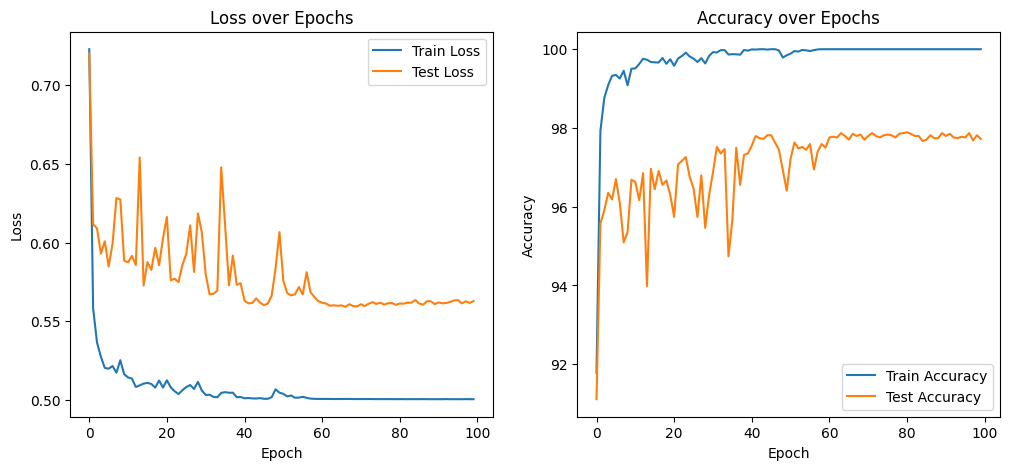

Classification Report for ResNet18:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       571
           1       0.99      1.00      0.99       626
           2       0.96      0.97      0.96       576
           3       0.98      0.98      0.98       484
           4       0.98      0.98      0.98       498
           5       0.96      0.97      0.97       412
           6       0.97      0.95      0.96       516
           7       0.99      0.99      0.99       575
           8       0.98      0.97      0.98       527
           9       0.99      1.00      1.00       615

    accuracy                           0.98      5400
   macro avg       0.98      0.98      0.98      5400
weighted avg       0.98      0.98      0.98      5400



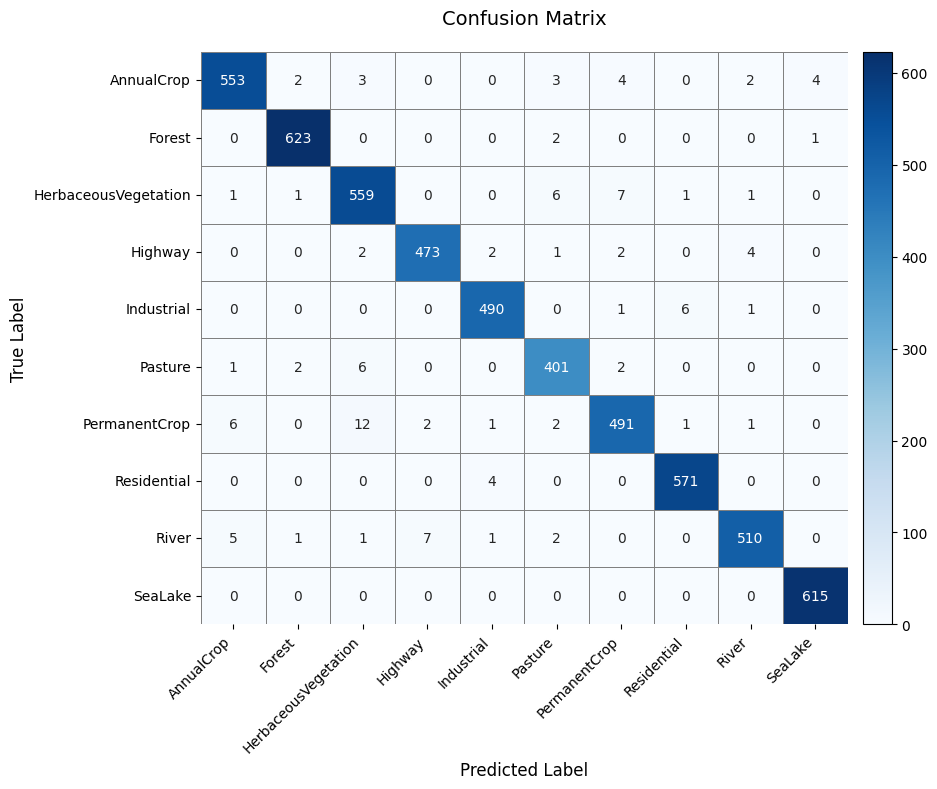

Training VGG16...


Training: 100%|██████████| 100/100 [26:51<00:00, 16.11s/it, test_acc=98.2, test_loss=1.12, train_acc=100, train_loss=1.02]


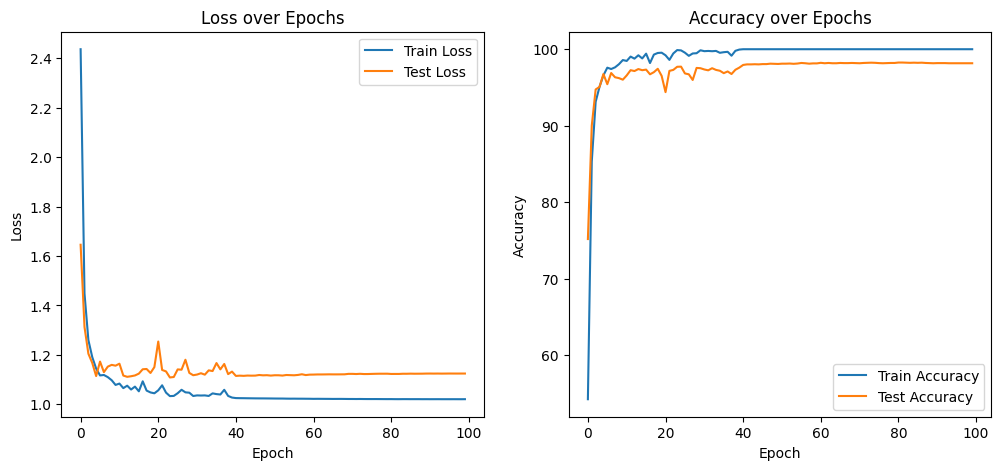

Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       571
           1       0.99      0.99      0.99       626
           2       0.97      0.98      0.97       576
           3       0.97      0.99      0.98       484
           4       0.99      0.98      0.99       498
           5       0.96      0.97      0.96       412
           6       0.98      0.96      0.97       516
           7       0.99      1.00      1.00       575
           8       1.00      0.97      0.98       527
           9       0.99      1.00      1.00       615

    accuracy                           0.98      5400
   macro avg       0.98      0.98      0.98      5400
weighted avg       0.98      0.98      0.98      5400



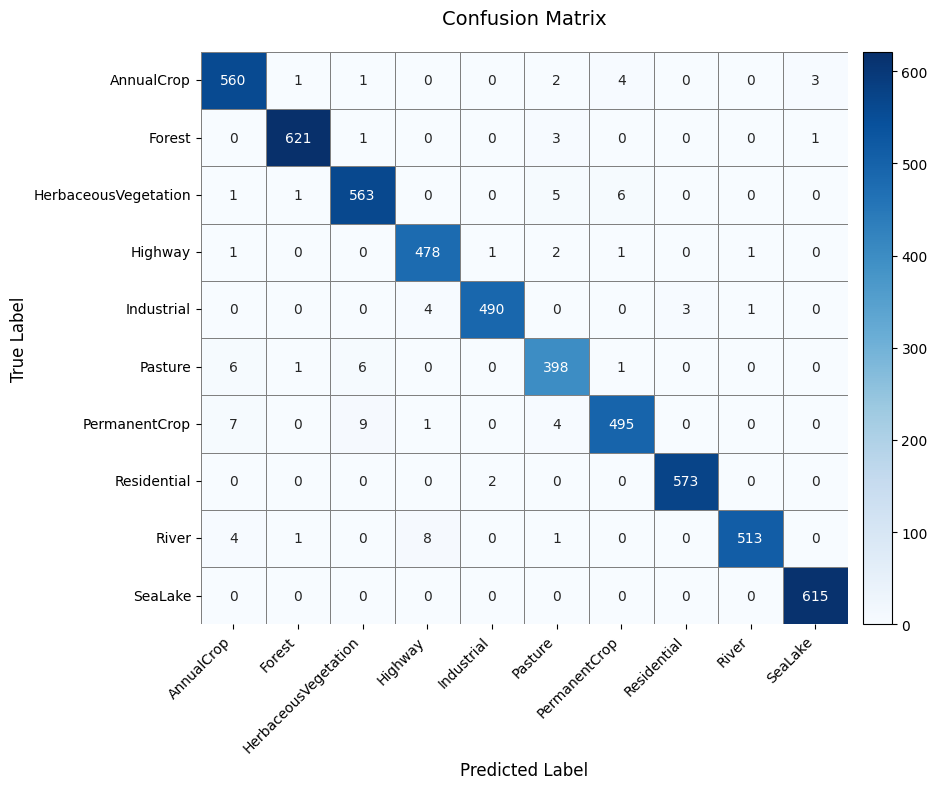

Training EfficientNetB0...


Training: 100%|██████████| 100/100 [10:19<00:00,  6.20s/it, test_acc=98.5, test_loss=1.08, train_acc=100, train_loss=1.02]


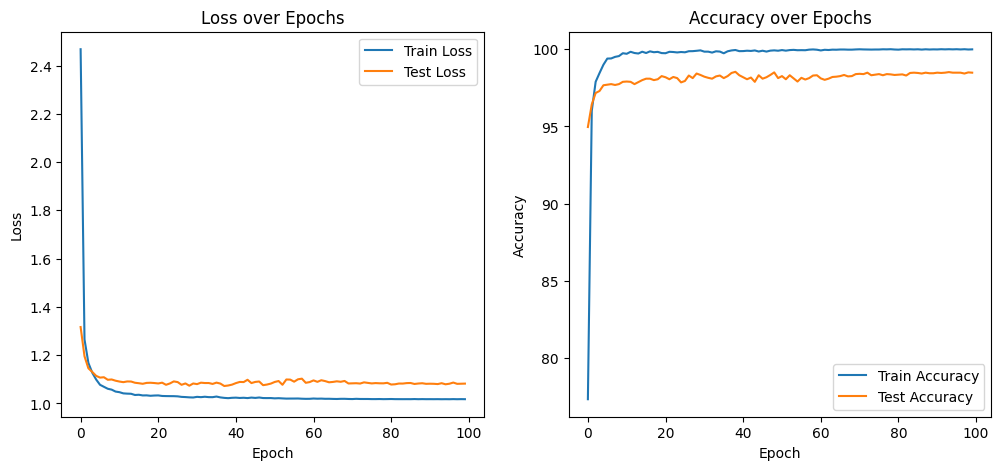

Classification Report for EfficientNetB0:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       571
           1       1.00      1.00      1.00       626
           2       0.98      0.99      0.98       576
           3       0.98      0.98      0.98       484
           4       0.99      0.99      0.99       498
           5       0.98      0.97      0.98       412
           6       0.98      0.97      0.97       516
           7       0.99      1.00      1.00       575
           8       0.99      0.97      0.98       527
           9       1.00      1.00      1.00       615

    accuracy                           0.99      5400
   macro avg       0.99      0.98      0.98      5400
weighted avg       0.99      0.99      0.99      5400



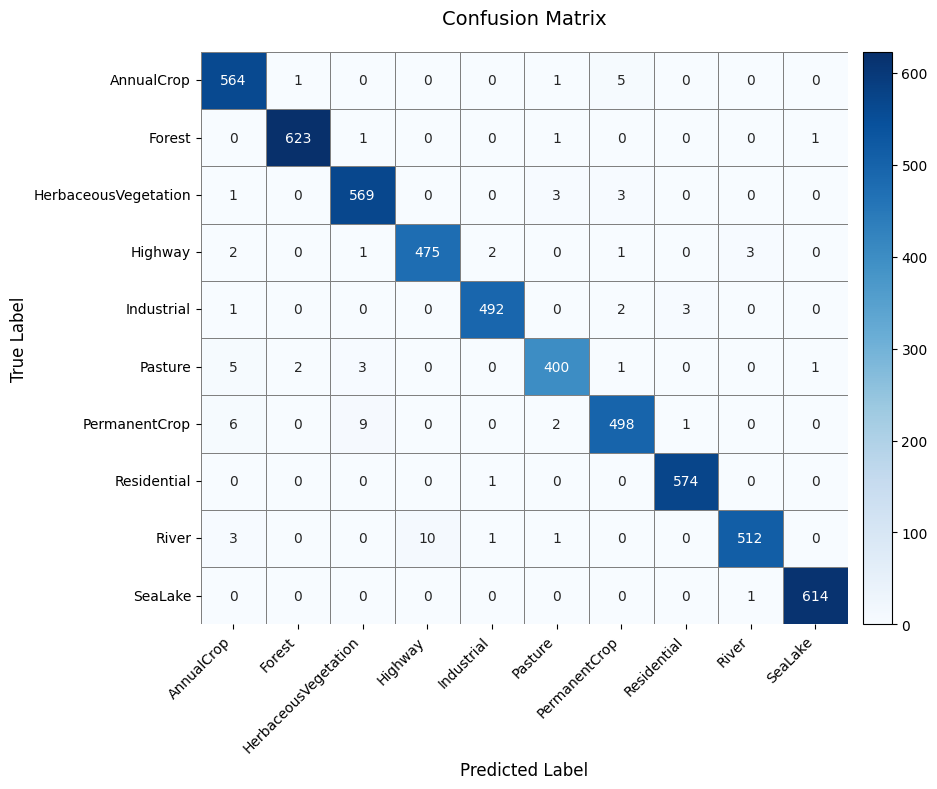

In [5]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

models_to_compare = {
    'ResNet18': models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1'),
    'VGG16': models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1'),
    'EfficientNetB0': models.efficientnet_b0(weights='EfficientNet_B0_Weights.IMAGENET1K_V1')
}

for model_name, model in models_to_compare.items():
    print(f'Training {model_name}...')
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES) if 'resnet' in model_name.lower() else nn.Linear(model.classifier[-1].in_features, NUM_CLASSES)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

    train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, model_name, train_loader, test_loader, criterion, optimizer, scheduler)

    plot_results(train_losses, test_losses, train_accuracies, test_accuracies)

    model.load_state_dict(torch.load(f'best_model_{model_name}.pth', weights_only=True))

    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f'Classification Report for {model_name}:')
    print(classification_report(all_labels, all_preds))

    plot_confusion_matrix(confusion_matrix(all_labels, all_preds), class_names)

### Выводы
- Для всех сетей 60 эпох достаточно для обучения
- По графику точности для тестовой выборки эффекта переобучения не выявлено
- EfficientNet имеет лучшие метрики и имеет более плавные кривые обучения. Точность на тестовой выборке достигает 99+%
- Для всех сетей оказалось затруднительным отличить дорогу от реки и типы растительности

